# Problemas de Difusión

Podriamos poner en cuestion ... porque razon separamos la discusion acerca de como tratar problemas gobernados por **conveccion** y problemas gobernados por **difusion**? Se intenta conservar una armonia entre el modelo matematico y el metodo numerico. Conveccion y difusion son procesos fisicos inherentemente distintos!

* *Proceso Convectivo* $\mapsto$ imagine un surfer montado a una ola alta, desplazandose rapidamente hacia la playa ... conveccion implica transporte, velocidad, direccion. La fisica tiene un sesgo direccional, y hemos comprobado que los metodos numericos deben ser compatibles con tal aspecto. Esta es la razon por la cual usamos metodos *upwind* para conveccion, y prestamos especial atencion a problemas de ondas que se mueven en direcciones opuestas, los cuales requieren esquemas especiales.


* *Proceso Difusivo* $\mapsto$ imagine una gota de tinta en un recipiente con agua, lentamente propagandose en todas direcciones hasta que todo el volumen de liquido en el recipiente adopte un color uniforme. La [difusion](http://en.wikipedia.org/wiki/Diffusion) dispersa la concentracion de algo alrededor (atomos, gente, ideas, suciedad, ...). Por tratarse de un proceso **NO** direccional, requerimos metodos numericos que sean isotropos (tales como diferencias centradas).

In [1]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/f/f9/Blausen_0315_Diffusion.png')

## PDEs de tipo Parabolico 

Ya hemos visto la PDE de tipo parabolico mas simple, la [ecuacion de difusion 1D](../modulo2/02_03_Difusion1D.ipynb) en el modulo 2. Aqui es:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

Veamos el articulo [parabolic PDEs](http://en.wikipedia.org/wiki/Parabolic_partial_differential_equation) en Wikipedia. Comparemos con la ecuacion de difusion escrita para las 2 variables independientes $x, t$. Podemos corroborar que en ausencia de derivadas cruzadas, y en presencia de una unica derivada de segundo orden (en la variable espacial $x$), la misma satisface la condicion de una PDE parabolica.

En el modulo 3, considerando leyes de conservacion de tipo hiperbolico, hemos visto que las soluciones tienen caracteristicas: la informacion viaja a lo largo de ciertos caminos en el espacio de fases espacio-tiempo. En contraste, las ecuaciones de tipo parabolico NO tienen caracteristicas, puesto que cualquier cambio local en la condicion inicial afectara eventualmente el dominio total, aunque su efecto se sienta en menor intensidad a mayores distancias.

## Conduccion de calor

La conduccion de calor es un proceso difusivo. Recordemos la ecuacion de calor 1D:

$$
\begin{equation}
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}
\end{equation}
$$

Aqui, $\alpha$ es la difusividad termica, una propiedad del material, y $T$ es la temperatura.

En el [cuaderno 3 del modulo 2](../modulo2/02_03_Difusion1D.ipynb) hemos discretizado la ecuacion de difusion con un esquema hacia adelante en tiempo y centrado en espacio, sujeto a la siguiente condicion de estabilidad:

$$
\begin{equation}
\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}
\end{equation}
$$

Veamos ahora con mayor detalle el problema de evolucion de temperatura 1D.

### Definicion del Problema

Consideremos una barra de grafito, con [difusividad termica](http://en.wikipedia.org/wiki/Thermal_diffusivity) $\alpha=1.22\times10^{-3} {\rm m}^2/{\rm s}$, longitud $L=1{\rm m}$, y temperatura $T=0^{\circ}{\rm C}$ uniforme. En el instante $t=0$, incrementamos la temperatura en el extremo izquierdo, $x=0$, a $T=100^{\circ}{\rm C}$. *Como evolucionara la temperatura en la barra?*

Comencemos importando algunas librerias y estableciendo los parametros de discretizacion. 

![graphite-rod](./figuras/graphite-rod.png)

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [13]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
# Set parameters.
L = 1.0  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1.22e-3  #  thermal diffusivity of the rod

# Define the locations along the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature along the rod.
T0 = numpy.zeros(nx)
T0[0] = 100.0

Recordemos el esquema de discretizacion *forward-time / centered space*:

$$
\begin{equation}
\frac{T_{i}^{n+1}-T_{i}^{n}}{\Delta t}=\alpha\frac{T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n}}{\Delta x^2}
\end{equation}
\hspace{2.7cm}(3)
$$

Para obtener la temperatura en el proximo paso de tiempo, $T^{n+1}_i$, a partir de la informacion conocida en el paso de tiempo actual, calculamos:

$$
\begin{equation}
T_{i}^{n+1}=T_{i}^{n}+\frac{\alpha\Delta t}{\Delta x^2}(T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n})
\end{equation}
\hspace{2cm}(4)
$$

La funcion siguiente implementa este esquema numerico:

In [5]:
def ftcs(T0, nt, dt, dx, alpha):
    """
    Computes and returns the temperature along the rod
    after a provided number of time steps,
    given the initial temperature and thermal diffusivity.
    The diffusion equation is integrated using forward 
    differencing in time and central differencing in space.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature along the rod as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    alpha : float
        The thermal diffusivity of the rod.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature along the rod as a 1D array of floats.
    """
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
    return T

Listos para correr! Previamente, fijemos un paso de tiempo `dt` que satisfaga la restriccion de estabilidad:

In [6]:
# Set the time-step size based on CFL limit.
nt = 100  # number of time steps to compute
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size

# Compute the temperature along the rod.
T = ftcs(T0, nt, dt, dx, alpha)

##### Nota
-----
En la funcion `ftcs`, *copiamos* el vector `T0`; de esta forma aseguramos que el valor de `T0` permanezca inalterado para su re-uso.

-----

Ahora grafiquemos la solucion!

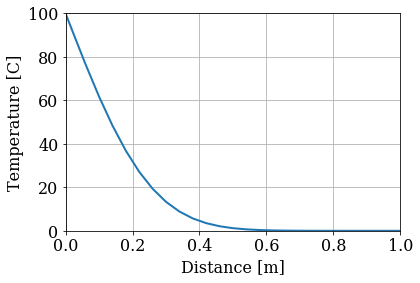

In [7]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

## Condiciones Frontera

En nuestro problema de la barra, fijamos el borde izquierdo a una temperatura $T = 100^{\circ}{\rm C}$. Esto constituye un ejemplo de *condicion de borde* (BC): una regla que define como el problema interactua con los bordes del dominio. En este caso, el dominio abarca la longitud de la barra, $0 \leq x \leq 1$.

Para citar otro ejemplo, en el [cuaderno 4 del modulo 2](../modulo2/02_04_Burgers1D.ipynb) hemos empleado una condicion de borde *periodica* a fin de "conectar" los bordes del dominio derecho e izquierdo.

### Condicion de Dirichlet 

El ejemplo de la barra emplea una BC tipo *Dirichlet* en el borde izquierdo. La condicion tipo Dirichlet es aquella en la cual el borde en cuestion se fija en un valor especifico de la variable solucion.

Que hay acerca del borde derecho de la barra $(x=1)$? En la discretizacion anterior, el problema no ha evolucionado un tiempo suficientemente largo como para que el calor viaje la longitud total de la barra. Incrementemos el numero de pasos de tiempo, `nt`, y veamos que sucede.

In [8]:
# Increase the number of time steps.
nt = 1000

# Compute the temperature along the rod.
T = ftcs(T0, nt, dt, dx, alpha)

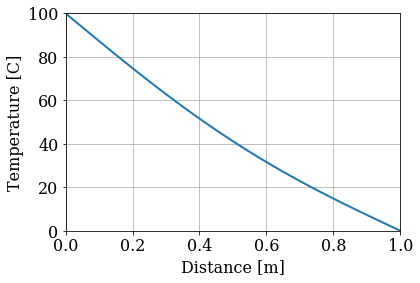

In [9]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

Hmmm ... luce como si hubiesemos fijado la BC del borde derecho al valor $T=0^{\circ}{\rm C}$.

Observando el codigo escrito para la funcion `ftcs`, vemos que el mismo **no** actualiza `T[-1]`, esto es el valor en el punto correspondiente al borde derecho de la grilla! Este valor se fija a cero en la condicion inicial y permanece en ese estado durante toda la simulacion. En efecto, tenemos una condicion de Dirichlet en *ambos* extremos. El borde izquierdo de la barra se mantiene a una temperatura $T = 100^{\circ}{\rm C}$ y el borde derecho se mantiene a $T = 0^{\circ}{\rm C}$. Por consiguiente, la distribucion de temperatura en la barra tendera (al cabo de un tiempo suficientemente largo) a un gradiente de temperatura *lineal*. Este hecho constituye un ejemplo de *solucion en Estado Estacionario* (tema que sera tratado en el modulo 5).

### Condicion de Neumann 

La condicion tipo Neumann es aquella en la cual se especifica el valor de la *derivada* de la solucion en el borde en cuestion.  

En nuestro ejemplo, si aplicamos una BC tipo Neumann al extremo derecho de la barra, podemos representarla matematicamente como:

$$
\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x = 1} = q(t)
\end{equation}
$$

Es posible implementarla en el codigo empleando una discretizacion en diferencias finitas de la derivada en la frontera. En el paso de tiempo $n$, para $N$ puntos, seria:

$$
\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x=1} \approx \frac{T^n_N - T^n_{N-1}}{\Delta x} = q(t)
\end{equation}
$$

En el contexto de la conduccion de calor, la derivada espacial de la temperatura es la densidad de flujo de calor $q$, esto es la cantidad de calor por unidad de tiempo, por unidad de area.

Por ejemplo, si la barra en $x=1$ presenta algun material aislante, **no** habra transferencia de calor a traves de aquel borde, y la condicion de borde tipo Neumann sera:

$$
\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x=1} = 0
\end{equation}
$$

Es decir, el cambio de temperatura al movernos en la direccion $x$ es cero en el extremo derecho de la barra. Esto implica que la temperatura deberia ser igual en los 2 ultimos puntos de grilla.

Para implementar esta BC tipo Neumann en el extremo derecho de la barra, agregamos la siguiente linea de codigo:

```Python
T[-1] = T[-2]
```

Esto es, la temperatura en la frontera (`T[-1]`) es igual a la temperatura directamente a su izquierda (`T[-2]`). El gradiente espacial sera cero y la condicion de Neumann sera satisfecha.

De esta forma, la condicion de Neumann requiere una actualizacion en cada iteracion del bucle.

Revisemos el problema de la barra. Esta vez, la temperatura en $x = 0$ permanecera fija en $T = 100^{\circ}{\rm C}$ --esta es la condicion Dirichlet-- mientras que una BC tipo Neumann se aplica en $x = 1$.

In [10]:
def ftcs_mixed_bcs(T0, nt, dt, dx, alpha):
    """
    Computes and returns the temperature along the rod
    after a provided number of time steps,
    given the initial temperature and the thermal diffusivity.
    The diffusion equation is integrated using forward 
    differencing in time and central differencing in space.
    The function uses a Dirichlet condition on the left side
    of the rod and a Neumann condition (zero-gradient) on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature along the rod as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    alpha : float
        The thermal diffusivity of the rod.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature along the rod as a 1D array of floats.
    """
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
        # Apply Neumann condition at the last location.
        T[-1] = T[-2]
    return T

In [11]:
nt = 1000  # number of time steps to compute

# Compute the temperature along the rod.
T = ftcs_mixed_bcs(T0, nt, dt, dx, alpha)

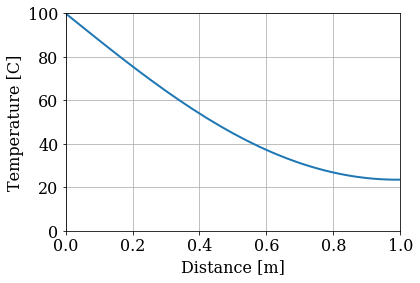

In [12]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

Ahora vemos que el calor se acumula en el dominio ... nuestro aislante funciona! Si incrementamos el numero de pasos de tiempo `nt`, notaremos que la temperatura en la seccion de salida ($x = 1$) aumentara.

### Esquemas explicitos y Condiciones de borde

Los esquemas numericos considerados hasta ahora se denominan *explicitos*, puesto que calculamos la solucion actualizada en $t^{n+1}$ empleando solo informacion conocida en $t^n$. Si bien este proceso es simple tiene limitaciones, particularmente en cuanto al reducido tamaño de paso requerido para lograr estabilidad.

Hay otro aspecto referido a los esquemas explicitos. La siguiente figura muestra el *stencil* superpuesto de varios puntos de grilla sobre 3 pasos de tiempo usando el esquema *forward-time / centered space*. Sabemos que para calcular $T_i^{n+1}$ empleamos la informacion de los puntos $i-1, i, i+1$ en el paso de tiempo anterior. Que sucede en la **frontera**? Cualquier cambio en la condicion de borde sera alimentado a la solucion unicamente en el proximo paso de tiempo, **no** en forma inmediata. Pero esto contradice la fisica del problema, segun la cual cualquier cambio en la frontera deberia sentirse **de inmediato** bajo la ecuacion de difusion. A fin de incluir efectos de borde en el mismo nivel temporal, emplearemos una actualizacion de tipo **implicita** (sujeto del proximo cuaderno).

![explicitFTCS-BCeffect](./figuras/explicitFTCS-BCeffect.png)

### Esquemas explicitos y Paso de tiempo

Reemplacemos el parametro $\sigma=\alpha \frac{\Delta t}{(\Delta x)^2}$ en la Ecuacion (4) y agrupemos los terminos que correspondan al punto de grilla $i$ en el lado derecho:

$$
\begin{equation}
T_{i}^{n+1} = \sigma T_{i-1}^{n}+(1- 2 \sigma) T_{i}^{n} + \sigma T_{i+1}^{n}
\end{equation}
$$

Resulta util observar el diagrama del *stencil* para la ecuacion de calor con los pesos que corresponden a la contribucion de cada punto de grilla. La siguiente figura ilustra los pesos para 2 valores de $\sigma$: $\frac{1}{2}$ y $1$. Notemos que usando $\sigma=\frac{1}{2}$, la variable solucion en el proximo paso de tiempo es *independiente* de su propio valor en el paso de tiempo actual. Mientras que usando $\sigma=1$, el valor actual afecta *negativamente* el valor futuro!

En efecto, la solucion desarrollara errores crecientes con $\sigma>\frac{1}{2}$, es decir, se torna **inestable**. Esto limita el paso de tiempo que puede ser empleado en forma significativa, puesto que $\Delta t \propto (\Delta x)^2$. Este hecho constituye un costo serio de los metodos **explicitos** y por lo tanto un incentivo a considerar alternativas **implicitas** (proximo cuaderno).

![stencil-weights](./figuras/stencil-weights.png)

---
###### The cell below loads the style of the notebook

In [14]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())